<a href="https://colab.research.google.com/github/rromerov/Proyecto_Integrador/blob/main/Demo/Demo.12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos**

### Avance 5: Modelo Final

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Ricardo Ambrocio Ramírez Mendoza  – Profesor Tutor

#### **Miembros del equipo:**
- Ernesto Enríquez Rubio - A01228409
- Roberto Romero Vielma - A00822314
- Herbert Joadan Romero Villarreal –  A01794199



---


## Demo
### Resumen de la demostración:

Esta demostración consiste en la recopilación de moléculas SMILES que no han sido utilizadas (vistas) ni por el modelo de regresión ni por el modelo pre-entrenado con finetuning. Esta recopilación de moléculas incluye SMILES que han demostrado cierta bioactividad para la inhibición de la proteína VEGF en general.

El procedimiento es el siguiete:

1.   Recopilación de nuevos SMILES
2.   Generar nuevas moléculas con marcadores comodín para esos SMILES
3.   Filtrado de moléculas válidas con RDKIT
4.   Conversión de moléculas SMILE modificadas a columnas binarias con PaDEL Descriptor
5.   Predicción de pIC50 estandarizado Min-Max para esas moléculas modificadas
6.   Transformación a valores pIC50 sin estandarización
7.   Comparación de pIC50 original y el pIC50 del SMILE modificado
8.   Visualización y graficación para apreciación de diferencias en la molécula





---

## Código de la demostración

Se importan las librerías necesarias y se instalan los paquetes de Python

In [1]:
%%capture
# Instalar librerias
! pip install datasets
! pip install transformers[torch]
! pip install accelerate -U
! pip install rdkit
! pip install rdkit-pypi
! pip install scikit-optimize

# Librería para búsqueda de nombre de moléculas
! pip install chembl_webresource_client

# Librería para búsqueda de nuevas moléculas con PubChem
! pip install beautifulsoup4 requests

In [2]:
# Importar librerías necesarias

# Librerías básicas
import pandas as pd
import numpy as np
from random import sample
import re
import sys
import os
import warnings
import time

# Librerías SKLearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler

# Libreria para procesamiento paralelo
import joblib
from joblib import Parallel, delayed, parallel_backend, parallel_config

# Libreria para desplegar numero de CPUs Colab
import multiprocessing as mp

# SK Librerías optimización
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

# Librerías para graficar
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías modelo para modelo MLM
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, RobertaForCausalLM, pipeline
from datasets import Dataset
import torch

# Librerías para trabajar con canonical smiles
from rdkit.Chem import rdchem
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import difflib

# Librerías Colab
from google.colab import data_table, drive

# Chembl Client
from chembl_webresource_client.new_client import new_client

# PubChem
import requests
from bs4 import BeautifulSoup

### 1. Recopilación de nuevos SMILES

In [58]:
# Lista de CIDs obtenidos manualmente de PubChem
cids = [5329468, 6419834, 5329155, 9797919, 9549295, 5329098, 135433815, 1401]  # Ejemplo de CIDs; reemplázalos con los obtenidos manualmente

In [59]:
# Función para obtener SMILES y valores IC50 de una lista de CIDs de PubChem
def get_smiles_and_ic50_from_cids(cids):
    data_list = []
    for cid in cids:
        url_smiles = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/CanonicalSMILES/JSON"
        url_bio = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/assaysummary/JSON"

        response_smiles = requests.get(url_smiles)
        response_bio = requests.get(url_bio)

        if response_smiles.status_code != 200 or response_bio.status_code != 200:
            continue

        smiles_data = response_smiles.json()
        bio_data = response_bio.json()

        properties = smiles_data.get('PropertyTable', {}).get('Properties', [])
        smiles = 'Unknown'
        for prop in properties:
            smiles = prop.get('CanonicalSMILES', 'Unknown')

        # Inicializar valor de IC50
        ic50 = 'Unknown'

        # Buscar valores de IC50 en los datos de bioactividad
        rows = bio_data.get('Table', {}).get('Row', [])
        for row in rows:
            cells = row.get('Cell', [])
            for i in range(len(cells)):
                if cells[i] == 'IC50':
                    ic50_value = cells[i - 1]
                    try:
                        ic50 = float(ic50_value)
                    except ValueError:
                        continue
                    break
            if ic50 != 'Unknown':
                break

        data_list.append({'CID': cid, 'canonical_smiles': smiles, 'IC50': ic50})

    return data_list

In [60]:
# Obtener los SMILES y valores IC50/pIC50 para los CIDs obtenidos
compound_data = get_smiles_and_ic50_from_cids(cids)

In [61]:
# Crear un DataFrame con los resultados
df_compounds = pd.DataFrame(compound_data)
df_compounds

,CID,canonical_smiles,IC50
0,5329468,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,0.387
1,6419834,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,100.000
2,5329155,C1CCC2=C(C1)C=C(N2)C=C3C4=C(C=CC(=C4)Br)NC3=O,100.000
3,9797919,C1=CC=C(C(=C1)C(=O)NC2=CC=C(C=C2)Cl)NCC3=CC=NC=C3,10.000
4,9549295,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,0.160
5,5329098,CC1=CC(=C(N1)C=C2C3=CC=CC=C3NC2=O)C,0.084
6,135433815,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,0.162
7,1401,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,20.000


In [62]:
# Función para normalizar IC50
def norm_value(input):
    # lista para guardar valores normalizados
    norm = []

    for i in input['IC50']:
        # valores mayores a 100000000 se quedan en 100000000
        if i > 100000000:
          i = 100000000
        # agregarlos a la lista
        norm.append(i)

    # nueva columna con valores estándar normalizados
    input['IC50_norm'] = norm
    # eliminar columna con los datos sin normalizar
    x = input.drop(columns='IC50')

    return x

In [63]:
# Función para obtener el pIC50
def pIC50(input):
  pIC50 = []
  for i in input['IC50_norm']:
    molar = i*(10**-9) # Convierte nM a M
    pIC50.append(-np.log10(molar))

  input['pIC50'] = pIC50
  x = input.drop(columns='IC50_norm')
  return x

In [64]:
# Normalizamos
df_compounds = norm_value(df_compounds)
df_compounds

,CID,canonical_smiles,IC50_norm
0,5329468,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,0.387
1,6419834,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,100.000
2,5329155,C1CCC2=C(C1)C=C(N2)C=C3C4=C(C=CC(=C4)Br)NC3=O,100.000
3,9797919,C1=CC=C(C(=C1)C(=O)NC2=CC=C(C=C2)Cl)NCC3=CC=NC=C3,10.000
4,9549295,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,0.160
5,5329098,CC1=CC(=C(N1)C=C2C3=CC=CC=C3NC2=O)C,0.084
6,135433815,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,0.162
7,1401,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,20.000


In [65]:
# Generamos pIC50
df_compounds = pIC50(df_compounds)
df_compounds

,CID,canonical_smiles,pIC50
0,5329468,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,9.412289
1,6419834,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,7.000000
2,5329155,C1CCC2=C(C1)C=C(N2)C=C3C4=C(C=CC(=C4)Br)NC3=O,7.000000
3,9797919,C1=CC=C(C(=C1)C(=O)NC2=CC=C(C=C2)Cl)NCC3=CC=NC=C3,8.000000
4,9549295,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9.795880
5,5329098,CC1=CC(=C(N1)C=C2C3=CC=CC=C3NC2=O)C,10.075721
6,135433815,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,9.790485
7,1401,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,7.698970


### 2. Generar nuevas moléculas con marcadores comodín para esos SMILES


#### Carga del modelo pre-entrenado con finetuning

In [66]:
# Cargar Google Drive al notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
# Verificar si CUDA está disponible y definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device in use: {device}')

Device in use: cpu


In [68]:
# Cargar el modelo y el tokenizador entrenados
model_name = "/content/drive/My Drive/Colab Notebooks/data/results"  # Directorio donde se guardaron los resultados del entrenamiento
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = RobertaForCausalLM.from_pretrained(model_name, is_decoder=True)  # Asegúrate de configurar el modelo como decodificador

# Crear el pipeline de fill-mask usando el modelo afinado
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

#### 3. Funciones para generación de SMILES

##### Filtrado de moléculas válidas con RDKIT

In [69]:
# Función para validar SMILES
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

In [70]:
# Función para remover átomos y agregar *
def remove_atoms_and_placeholder(smiles, num_atoms_to_remove=1):
    # Redirigir stderr para silenciar errores de RDKit
    stderr = sys.stderr
    sys.stderr = open(os.devnull, 'w')

    try:
        # Convertir SMILES a una molécula RDKit
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None, None

        # Seleccionar átomos al azar para eliminar
        atoms_to_remove = sample(range(mol.GetNumAtoms()), num_atoms_to_remove)

        # Crear una copia editable de la molécula
        mol_edit = rdchem.RWMol(mol)

        # Remover átomos
        for idx in sorted(atoms_to_remove, reverse=True):
            mol_edit.ReplaceAtom(idx, rdchem.Atom('*'))

        # Convertir la molécula modificada de nuevo a SMILES
        modified_smiles = Chem.MolToSmiles(mol_edit)

    finally:
        # Restaurar stderr
        sys.stderr.close()
        sys.stderr = stderr

    return modified_smiles

In [71]:
%%capture
# Número de veces a ejecutar el generador por cada SMILE
# Tomando en cuenta que por cada vez, se generan 5 smiles modificados
# Pero que no todos son modificaciones atómicas válidas
samples_per_smile = 5

# Ejemplo de múltiples secuencias SMILES con placeholders en diferentes posiciones
smiles_list = df_compounds['canonical_smiles']

# DataFrame para almacenar los resultados
results_list = []

# Generar secuencias completas para cada SMILES en la lista
for idx, smiles in enumerate(smiles_list):
    modified_smiles_list = []  # Lista para almacenar las secuencias modificadas
    for _ in range(samples_per_smile):  # Ejecutar 5 veces la función remove_atoms_and_placeholder
        modified_smiles = remove_atoms_and_placeholder(smiles, num_atoms_to_remove=1)
        if modified_smiles:
            modified_smiles_list.append(modified_smiles)

    # Procesar cada secuencia modificada obtenida
    for modified_smiles in modified_smiles_list:
        modified_smiles_with_mask = modified_smiles.replace('*', '<mask>')

        # Usar el pipeline para llenar las máscaras
        results = fill_mask(modified_smiles_with_mask)

        # Procesar los resultados y almacenar en la lista de resultados
        for res in results:
            sequence = res['sequence']
            sequence = sequence.replace('<s>', '').replace('</s>', '').strip()
            if is_valid_smiles(sequence):
                results_list.append({
                    'Original_SMILES': smiles,
                    'Modified_SMILES': sequence,
                    'Group': idx
                })

# Crear el DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

# Filtrar filas donde el Original_SMILES sea igual al Modified_SMILES
results_df = results_df[results_df['Original_SMILES'] != results_df['Modified_SMILES']]

In [72]:
# Mostrar el DataFrame resultante
results_df = results_df.reset_index(drop=True)
results_df

,Original_SMILES,Modified_SMILES,Group
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0
...,...,...,...
73,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=...,7
74,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7
75,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7
76,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC...,7


In [73]:
# Seleccionar solo la columna 'CID' del DataFrame original
df_subset = df_compounds[['CID']]

# Añadir la columna 'CID' al DataFrame results_df
merged_df = pd.merge(results_df, df_subset, left_on='Group', right_index=True)

In [74]:
# Mostrar el DataFrame resultante
merged_df = merged_df.reset_index(drop=True)
merged_df

,Original_SMILES,Modified_SMILES,Group,CID
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
...,...,...,...,...
73,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=...,7,1401
74,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7,1401
75,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7,1401
76,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC...,7,1401


In [75]:
# Remover moléculas modificadas que sean iguales a las originales
merged_df = merged_df[merged_df['Original_SMILES'] != merged_df['Modified_SMILES']]
merged_df

,Original_SMILES,Modified_SMILES,Group,CID
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
...,...,...,...,...
73,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=...,7,1401
74,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7,1401
75,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7,1401
76,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC...,7,1401


In [76]:
# Eliminar filas duplicadas basadas en la columna 'Modified_SMILES'
merged_df = merged_df.drop_duplicates(subset='Modified_SMILES')

# Mostrar el DataFrame resultante
merged_df

,Original_SMILES,Modified_SMILES,Group,CID
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468
...,...,...,...,...
73,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=...,7,1401
74,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7,1401
75,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7,1401
76,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC...,7,1401


In [77]:
# Agregar identificador para las nuevas moléculas usando .loc
merged_df.loc[:, 'molecule_id'] = range(1, len(merged_df) + 1)

<ipython-input-77-a4cd71d01a65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.loc[:, 'molecule_id'] = range(1, len(merged_df) + 1)


In [78]:
# Guardamos el DataFrame con la lista de todos los Modified_SMILES válidos
merged_df.to_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_new_molecules_demo.csv', index=False)
merged_df.to_csv('./bioactivity_data_new_molecules_demo.csv', index=False)

In [79]:
# Cargar CSV
merged_df = pd.read_csv('./bioactivity_data_new_molecules_demo.csv')

In [80]:
# Mostrar df
merged_df

,Original_SMILES,Modified_SMILES,Group,CID,molecule_id
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468,1
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468,2
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468,3
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468,4
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468,5
...,...,...,...,...,...
69,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=...,7,1401,70
70,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7,1401,71
71,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7,1401,72
72,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC...,7,1401,73


### 4. Conversión de moléculas SMILE con PaDEL Descriptor

In [81]:
# Columnas de interés para el descriptor PADEL
columnas = ['Modified_SMILES','molecule_id']
df_selection = merged_df[columnas]
df_selection

,Modified_SMILES,molecule_id
0,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,1
1,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,2
2,CCNc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,3
3,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,4
4,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,5
...,...,...
69,CCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=...,70
70,CCCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,71
71,CCNc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,72
72,CCNCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC...,73


In [82]:
# Guardar en un archivo SMI
# En drive
df_selection.to_csv('/content/drive/My Drive/Colab Notebooks/data/new_molecule_demo.smi', sep='\t', index=False, header=False)
# Local
df_selection.to_csv('new_molecule.smi', sep='\t', index=False, header=False)

In [83]:
# Visualizar las moleculas guardadas
! cat '/content/drive/My Drive/Colab Notebooks/data/new_molecule_demo.smi' | head -5

CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1	1
CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1	2
CCNc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1	3
CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1	4
CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1	5


In [84]:
# Número de registros
! cat '/content/drive/My Drive/Colab Notebooks/data/new_molecule_demo.smi' | wc -l

74


**Cálculo de descriptores con PaDEL**


In [85]:
%%capture
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

!cp -rf "padel.zip" "/content/drive/My Drive/Colab Notebooks/data/padel.zip"
!cp -rf "padel.sh" "/content/drive/My Drive/Colab Notebooks/data/padel.sh"

!cp -rf "/content/drive/My Drive/Colab Notebooks/data/padel.zip" "padel.zip"
!cp -rf "/content/drive/My Drive/Colab Notebooks/data/padel.sh" "padel.sh"

In [86]:
# Descomprimimos padel sin Output en consola
%%capture
! unzip -o padel.zip

In [87]:
# Inspeccionamos el script de PaDEL que nos ayudará a generar los descriptores
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [88]:
# Calculamos los descriptores con PaDEL sin Output en consola
%%capture
! bash padel.sh

In [89]:
# Guardamos el output como csv
!cp -rf "descriptors_output.csv" "/content/drive/My Drive/Colab Notebooks/data/descriptors_output_new_mol_demo.csv"

In [90]:
# Mostrar descriptores calculados con Padel
fingerprints_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/descriptors_output_new_mol_demo.csv')
fingerprints_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,70,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,71,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,72,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72,73,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# Guardar en drive el dataset
fingerprints_df.to_csv('/content/drive/My Drive/Colab Notebooks/data/pubchem_fp_new_mol_demo.csv', index=False)

### 5. Predicción de pIC50 estandarizado Min-Max para esas moléculas modificadas

In [92]:
# Usar nuevo dataset
df_new_mol = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/pubchem_fp_new_mol_demo.csv')
df_new_mol

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,70,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,71,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,72,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72,73,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
# Se define conjunto X_new_mol para los fingerprints de las nuevas moléculas
X_new_mol = df_new_mol.drop('Name', axis=1)
# Mostrar contenido en el conjunto de X_new_mol
X_new_mol

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
70,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
71,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
72,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


##### **Nuevas moléculas con mejor pIC50**

In [94]:
# Cargar el modelo desde el archivo
stacking_model = joblib.load('/content/drive/My Drive/Colab Notebooks/data/stacking_model.pkl')

# Usar el modelo para hacer predicciones
Y_pred_new_mol = stacking_model.predict(X_new_mol)

In [95]:
# Obtener las posiciones de las 10 predicciones más altas
top_10_indices = Y_pred_new_mol.argsort()[-10:][::-1]

# Obtener los nombres (Name) de estas moléculas
top_10_names = df_new_mol.iloc[top_10_indices]['Name'].values

# Filtrar fingerprints_df para obtener molecule_id
top_10_ids = fingerprints_df[fingerprints_df['Name'].isin(top_10_names)]

# Unir con df_selection para obtener las SMILES canónicas
top_10_smiles = df_selection[df_selection['molecule_id'].isin(top_10_ids['Name'])]

# Unir los resultados para tener un dataframe con SMILES y pIC50
result = top_10_smiles.merge(top_10_ids, left_on='molecule_id', right_on='Name')
result['pIC50'] = Y_pred_new_mol[top_10_indices]

# Seleccionar las columnas de interés
result = result[['Modified_SMILES', 'pIC50']]

# Mostrar las primeras 10 moléculas con mayor pIC50 y sus SMILES
result


,Modified_SMILES,pIC50
0,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.646188
1,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.606089
2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.593547
3,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.590994
4,COc1ccc(-c2cnc3c(-c4ccsc4)c:c:n3c2)cc1,0.584742
5,COc1ccc(-c2cnc3c(-c4ccsc4)c:n:n3c2)cc1,0.584742
6,COOCC1:ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc:1,0.583514
7,Oc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=O...,0.568769
8,CSOc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,0.564637
9,CCN(CC)CCCCNc1n:n:c2cc(-c3cc(OC)cc(OC)c3)c(NC(...,0.561656


In [96]:
# Exportar a csv el dataset
result.to_csv('/content/drive/My Drive/Colab Notebooks/data/new_molecule_pIC50_demo.csv', index=False)

In [97]:
# Guardar archivos en un archivo zip
! zip -r /content/drive/My\ Drive/Colab\ Notebooks/data/results_demo.zip /content/drive/My\ Drive/Colab\ Notebooks/data

updating: content/drive/My Drive/Colab Notebooks/data/ (stored 0%)
updating: content/drive/My Drive/Colab Notebooks/data/results/ (stored 0%)
updating: content/drive/My Drive/Colab Notebooks/data/results/tokenizer_config.json (deflated 76%)
updating: content/drive/My Drive/Colab Notebooks/data/results/special_tokens_map.json (deflated 84%)
updating: content/drive/My Drive/Colab Notebooks/data/results/config.json (deflated 48%)
updating: content/drive/My Drive/Colab Notebooks/data/results/tokenizer.json (deflated 79%)
updating: content/drive/My Drive/Colab Notebooks/data/results/merges.txt (deflated 71%)
updating: content/drive/My Drive/Colab Notebooks/data/results/vocab.json (deflated 67%)
updating: content/drive/My Drive/Colab Notebooks/data/results/generation_config.json (deflated 29%)
updating: content/drive/My Drive/Colab Notebooks/data/results/model.safetensors (deflated 7%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_3class_pIC50_pubchem_fp.csv (deflate



---

### Comparación moléculas modificadas vs moléculas originales





In [98]:
# Cargar el dataset
ruta_archivo_modified_molecules = '/content/drive/My Drive/Colab Notebooks/data/new_molecule_pIC50_demo.csv'

# Lee el archivo CSV en un DataFrame
df_modified_molecules = pd.read_csv(ruta_archivo_modified_molecules)

# Mostrar que se haya importado correctamente el archivo
df_modified_molecules

,Modified_SMILES,pIC50
0,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.646188
1,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.606089
2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.593547
3,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.590994
4,COc1ccc(-c2cnc3c(-c4ccsc4)c:c:n3c2)cc1,0.584742
5,COc1ccc(-c2cnc3c(-c4ccsc4)c:n:n3c2)cc1,0.584742
6,COOCC1:ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc:1,0.583514
7,Oc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=O...,0.568769
8,CSOc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,0.564637
9,CCN(CC)CCCCNc1n:n:c2cc(-c3cc(OC)cc(OC)c3)c(NC(...,0.561656


In [99]:
# Cargar el dataset
ruta_archivo_new_molecules = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_new_molecules_demo.csv'

# Lee el archivo CSV en un DataFrame
df_new_molecules = pd.read_csv(ruta_archivo_new_molecules)

# Mostrar que se haya importado correctamente el archivo
df_new_molecules

,Original_SMILES,Modified_SMILES,Group,CID,molecule_id
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468,1
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468,2
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468,3
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468,4
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0,5329468,5
...,...,...,...,...,...
69,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=...,7,1401,70
70,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7,1401,71
71,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7,1401,72
72,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCNCc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC...,7,1401,73


In [100]:
# Asegurarse de que ambos DataFrames tienen la columna 'Modified_SMILES' para realizar la fusión
# Fusionar los DataFrames usando 'Modified_SMILES' como clave
merged_df_original_modified = pd.merge(df_modified_molecules, df_new_molecules[['Modified_SMILES', 'Original_SMILES', 'CID']], on='Modified_SMILES', how='inner')

# Renombrar la columna 'pIC50' a 'Predicted_pIC50'
merged_df_original_modified = merged_df_original_modified.rename(columns={'pIC50': 'Predicted_pIC50'})

# Mostrar el DataFrame resultante
merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,CID
0,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.646188,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
1,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.606089,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.593547,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
3,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,0.590994,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
4,COc1ccc(-c2cnc3c(-c4ccsc4)c:c:n3c2)cc1,0.584742,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
5,COc1ccc(-c2cnc3c(-c4ccsc4)c:n:n3c2)cc1,0.584742,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
6,COOCC1:ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc:1,0.583514,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
7,Oc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=O...,0.568769,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401
8,CSOc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,0.564637,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401
9,CCN(CC)CCCCNc1n:n:c2cc(-c3cc(OC)cc(OC)c3)c(NC(...,0.561656,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401


In [101]:
# Supongamos que estos eran los valores mínimo y máximo originales de pIC50
min_pIC50 = 2.389233405226729  # Reemplaza con el valor mínimo original de pIC50
max_pIC50 = 10.638272163982407 # Reemplaza con el valor máximo original de pIC50

# Función para desescalar manualmente
def invert_scaling(scaled_value, min_val, max_val):
    return scaled_value * (max_val - min_val) + min_val

# Aplicar la función de desescalado manualmente
merged_df_original_modified['Predicted_pIC50'] = merged_df_original_modified['Predicted_pIC50'].apply(invert_scaling, args=(min_pIC50, max_pIC50))

merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,CID
0,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.719666,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
1,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.388885,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.285426,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
3,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.264365,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
4,COc1ccc(-c2cnc3c(-c4ccsc4)c:c:n3c2)cc1,7.212794,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
5,COc1ccc(-c2cnc3c(-c4ccsc4)c:n:n3c2)cc1,7.212794,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
6,COOCC1:ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc:1,7.202665,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468
7,Oc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=O...,7.081027,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401
8,CSOc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7.046943,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401
9,CCN(CC)CCCCNc1n:n:c2cc(-c3cc(OC)cc(OC)c3)c(NC(...,7.022358,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401


In [102]:
# Lee el archivo CSV en un DataFrame
df_main_all_pIC50 = df_compounds.copy()

# Mostrar que se haya importado correctamente el archivo
df_main_all_pIC50

,CID,canonical_smiles,pIC50
0,5329468,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,9.412289
1,6419834,CCOC(=O)C1=C(NC(=C1C)C=C2C3=CC=CC=C3NC2=O)C,7.000000
2,5329155,C1CCC2=C(C1)C=C(N2)C=C3C4=C(C=CC(=C4)Br)NC3=O,7.000000
3,9797919,C1=CC=C(C(=C1)C(=O)NC2=CC=C(C=C2)Cl)NCC3=CC=NC=C3,8.000000
4,9549295,CCCNC(=O)NC1=C(C=C(C=C1)OC2=NC=NC3=CC(=C(C=C32...,9.795880
5,5329098,CC1=CC(=C(N1)C=C2C3=CC=CC=C3NC2=O)C,10.075721
6,135433815,C1=CC=C2C(=C1)C(=C(C(=O)N2)C3=NC4=CC=CC=C4N3)O,9.790485
7,1401,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,7.698970


In [103]:
# Fusionar los DataFrames usando 'molecule_chembl_id' como clave
merged_df_original_modified = pd.merge(merged_df_original_modified, df_main_all_pIC50[['CID', 'pIC50']], on='CID', how='left')

# Renombrar la columna 'pIC50' a 'Original_pIC50'
merged_df_original_modified = merged_df_original_modified.rename(columns={'pIC50': 'Original_pIC50'})

# Mostrar el DataFrame resultante
merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,CID,Original_pIC50
0,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.719666,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289
1,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.388885,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289
2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.285426,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289
3,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.264365,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289
4,COc1ccc(-c2cnc3c(-c4ccsc4)c:c:n3c2)cc1,7.212794,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289
5,COc1ccc(-c2cnc3c(-c4ccsc4)c:n:n3c2)cc1,7.212794,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289
6,COOCC1:ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc:1,7.202665,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289
7,Oc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=O...,7.081027,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401,7.698970
8,CSOc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7.046943,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401,7.698970
9,CCN(CC)CCCCNc1n:n:c2cc(-c3cc(OC)cc(OC)c3)c(NC(...,7.022358,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401,7.698970


In [104]:
# Función para obtener el nombre de la molécula a partir del CID de PubChem
def get_molecular_formula(cid):
    try:
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularFormula/JSON"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            formula = data.get('PropertyTable', {}).get('Properties', [{}])[0].get('MolecularFormula', 'Unknown')
            return formula
        else:
            return 'Unknown'
    except:
        return 'Unknown'

# Aplicar la función para obtener las fórmulas moleculares y crear una nueva columna
merged_df_original_modified['Molecular_Formula'] = merged_df_original_modified['CID'].apply(get_molecular_formula)

# Mostrar el DataFrame resultante
merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,CID,Original_pIC50,Molecular_Formula
0,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.719666,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289,C17H13N3OS
1,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.388885,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289,C17H13N3OS
2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.285426,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289,C17H13N3OS
3,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,7.264365,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289,C17H13N3OS
4,COc1ccc(-c2cnc3c(-c4ccsc4)c:c:n3c2)cc1,7.212794,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289,C17H13N3OS
5,COc1ccc(-c2cnc3c(-c4ccsc4)c:n:n3c2)cc1,7.212794,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289,C17H13N3OS
6,COOCC1:ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc:1,7.202665,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,5329468,9.412289,C17H13N3OS
7,Oc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=O...,7.081027,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401,7.698970,C28H41N7O3
8,CSOc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,7.046943,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401,7.698970,C28H41N7O3
9,CCN(CC)CCCCNc1n:n:c2cc(-c3cc(OC)cc(OC)c3)c(NC(...,7.022358,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,1401,7.698970,C28H41N7O3


In [105]:
# Función para obtener las diferencias entre dos strings
def get_differences(original, modified):
    diff = difflib.ndiff(original, modified)
    changes = [d for d in diff if d.startswith('- ') or d.startswith('+ ')]
    return changes

# Aplicar la función para obtener las diferencias y crear una nueva columna
merged_df_original_modified['Differences'] = merged_df_original_modified.apply(
    lambda row: get_differences(row['Original_SMILES'], row['Modified_SMILES']),
    axis=1
)

# Mostrar el DataFrame resultante con las diferencias
merged_df_original_modified[['Original_SMILES', 'Modified_SMILES', 'Differences']]


,Original_SMILES,Modified_SMILES,Differences
0,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,"[- C, - O, - C, - 1, - =, - =, - C, + c, + 1, ..."
1,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,"[- C, - O, - C, - 1, - =, - =, + c, + 1, + c, ..."
2,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCNCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,"[- C, - O, - C, - 1, - =, - =, + N, + c, + 1, ..."
3,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,CCCCc1ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc1,"[- C, - O, - C, - 1, - =, - =, + C, + c, + 1, ..."
4,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4ccsc4)c:c:n3c2)cc1,"[- C, + c, + c, + c, + c, - =, - C, - C, - =, ..."
5,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COc1ccc(-c2cnc3c(-c4ccsc4)c:n:n3c2)cc1,"[- C, + c, + c, + c, + c, - =, - C, - C, - =, ..."
6,COC1=CC=C(C=C1)C2=CN3C(=C(C=N3)C4=CSC=C4)N=C2,COOCC1:ccc(-c2cnc3c(-c4ccsc4)cnn3c2)cc:1,"[+ O, + C, + :, + c, + c, + c, - =, - C, - C, ..."
7,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,Oc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(=O...,"[+ O, + c, + 1, + c, + c, + (, + O, + C, + ), ..."
8,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CSOc1cc(OC)cc(-c2cc3cnc(NCCCCN(CC)CC)nc3nc2NC(...,"[+ C, + S, + O, + c, + 1, + c, + c, + (, + O, ..."
9,CCN(CC)CCCCNC1=NC2=NC(=C(C=C2C=N1)C3=CC(=CC(=C...,CCN(CC)CCCCNc1n:n:c2cc(-c3cc(OC)cc(OC)c3)c(NC(...,"[- C, + c, - =, - N, - C, + n, + :, + n, + :, ..."


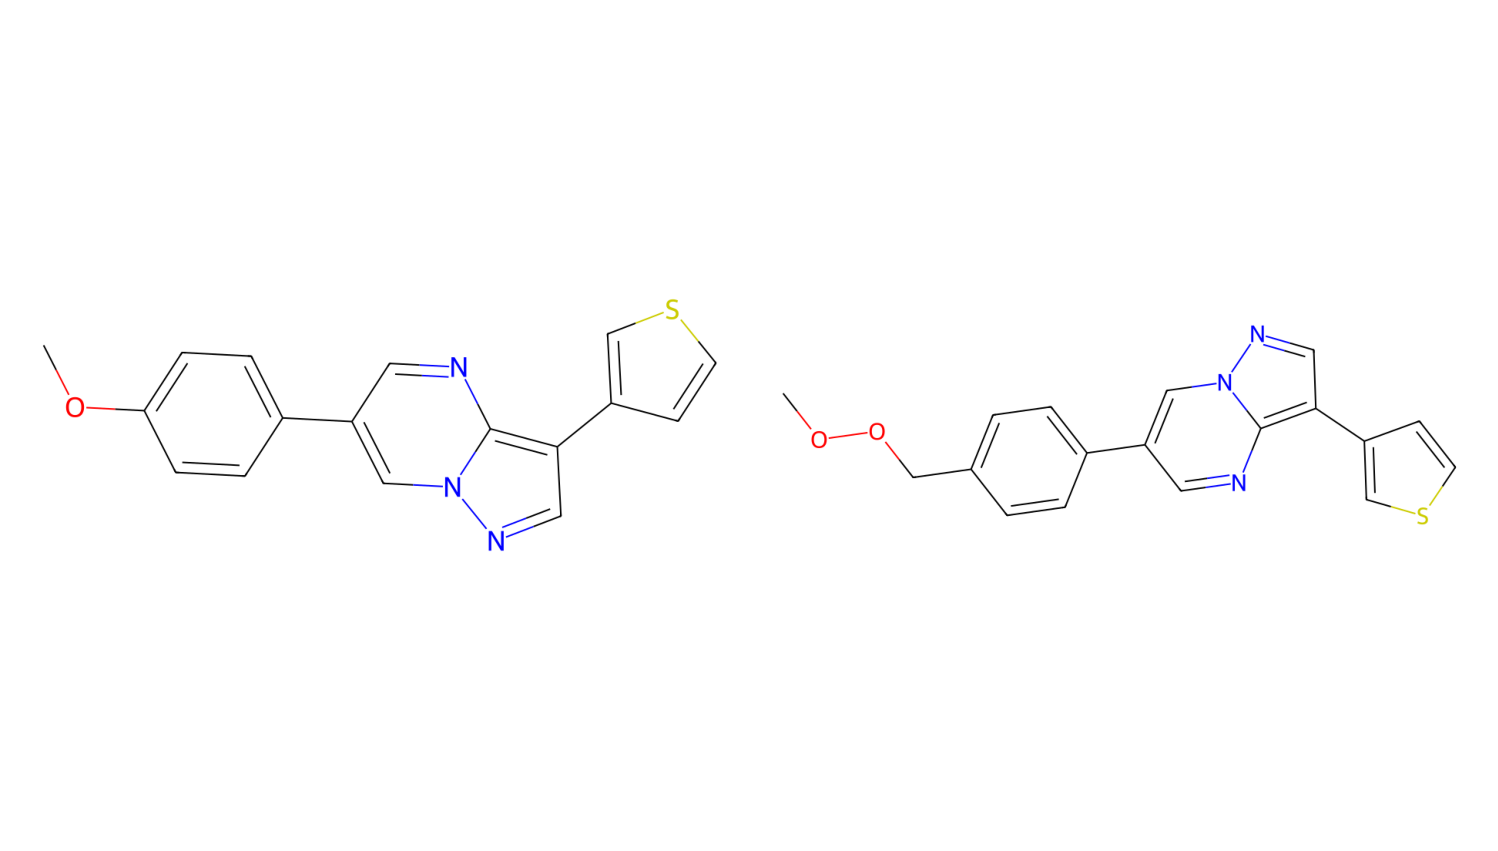

In [106]:
# Función para visualizar moléculas lado a lado usando PIL y matplotlib en calidad Full HD
def visualize_molecules(df, index):
    original_smiles = df.loc[index, 'Original_SMILES']
    modified_smiles = df.loc[index, 'Modified_SMILES']

    original_mol = Chem.MolFromSmiles(original_smiles)
    modified_mol = Chem.MolFromSmiles(modified_smiles)

    original_img = Draw.MolToImage(original_mol, size=(960, 1080))
    modified_img = Draw.MolToImage(modified_mol, size=(960, 1080))

    # Crear una nueva imagen en blanco lo suficientemente grande para ambas moléculas
    combined_img = Image.new('RGB', (1920, 1080))
    combined_img.paste(original_img, (0, 0))
    combined_img.paste(modified_img, (960, 0))

    return combined_img

# Visualizar las moléculas de la primera fila
image = visualize_molecules(merged_df_original_modified, 6)

# Ajustar el tamaño de la figura
plt.figure(figsize=(19.2, 10.8))  # Ajusta el tamaño de la figura (ancho, alto) en pulgadas para mantener la relación 1920x1080

# Mostrar la imagen usando matplotlib
plt.imshow(image)
plt.axis('off')  # Ocultar los ejes
plt.show()


### Conclusión

TODO

## Referencias bibliográficas

TODO